In [1]:
import sys
import numpy as np
import xarray as xr
from scipy.io import loadmat
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
sys.path.append('/Users/jakesteinberg/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# procedure 
# - units of time have to be the same
# - remove time mean, linear trend, and seasonal cycle? 
# steric height     [time x location] 
#    map to regular grid 
# coastal sea level [time x location]

In [2]:
## Set top-level file directory for the ECCO NetCDF files
## =================================================================
base_dir = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/'   # # base_dir = '/home/username/'
ECCO_dir = base_dir + '/v4'                                    ## define a high-level directory for ECCO fields
grid_dir= ECCO_dir + '/nctiles_grid/'                          ## Load the model grid
ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCO-GRID.nc')   # ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCOv4r3_grid.nc', k_subset=[0])
## -- Load 2D Monthly data...SSH -- 
data_dir= ECCO_dir + '/nctiles_monthly'
ecco_daily_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir, vars_to_load=['SSHDYN','OBPNOPAB'],\
                                           years_to_load=range(2008,2018)).load()                                       
## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ecco_monthly_ds = xr.merge((ecco_grid , ecco_daily_vars))

loading files of  OBPNOPAB
loading files of  SSHDYN


In [3]:
ocean_mask = np.ceil(ecco_monthly_ds.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)
total_ocean_area = np.sum(ecco_monthly_ds.rA*ocean_mask[0,:])

In [6]:
# global area weighted mean SSH,OBP 
SSHDYN_global_mean_mon = (ecco_monthly_ds.SSHDYN*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area
SSHDYN_global_mean_mon = SSHDYN_global_mean_mon - SSHDYN_global_mean_mon.mean(dim=['time'])
OBP_global_mean_mon = ((ecco_monthly_ds.OBPNOPAB)*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area
OBP_global_mean_mon = OBP_global_mean_mon - OBP_global_mean_mon.mean(dim=['time'])
steric_height_global_mean =  SSHDYN_global_mean_mon - OBP_global_mean_mon

In [4]:
steric_height = ecco_monthly_ds.SSHDYN - ecco_monthly_ds.OBPNOPAB
steric_height_anom = steric_height - steric_height.mean(dim='time')

-179.75 179.75
-180.0 180.0
-89.75 89.75
-90.0 90.0


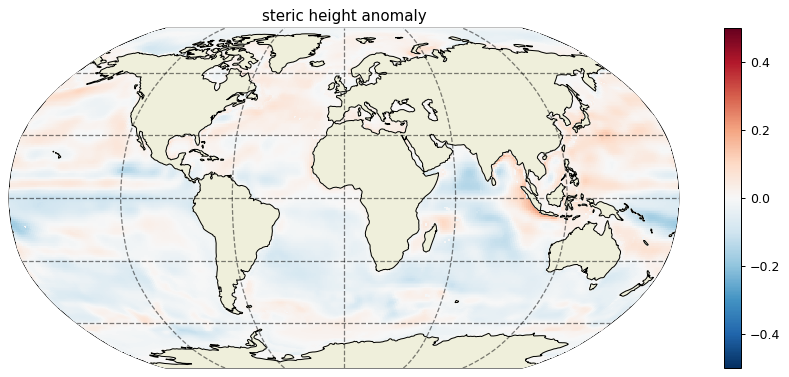

In [6]:
f1 = plt.figure(figsize=(13,5), dpi= 90)
ecco.plot_proj_to_latlon_grid(ecco_monthly_ds.XC, ecco_monthly_ds.YC, steric_height[10] - steric_height.mean(dim='time'), \
                              user_lon_0=0,plot_type='pcolormesh',show_colorbar=True, cmin=-0.5, cmax=0.5, dx=0.5, dy=0.5); # cmin=-0.3, cmax=0.3
plt.title('steric height anomaly');

In [7]:
# OLD 
# for now just select one tile 
tile_num = 10
sha10 = steric_height_anom.sel(tile=tile_num)
lons = np.copy(ecco_monthly_ds.XC.sel(tile=tile_num))
lats = ecco_monthly_ds.YC.isel(tile=tile_num)

In [29]:
# regrid from ecco tiles 
new_grid_delta_lat = 1
new_grid_delta_lon = 1
new_grid_min_lat = -80+new_grid_delta_lat/2
new_grid_max_lat = 80-new_grid_delta_lat/2
new_grid_min_lon = -150+new_grid_delta_lon/2
new_grid_max_lon = 30-new_grid_delta_lon/2
new_grid_lat = np.arange(-80+new_grid_delta_lat/2, 80-new_grid_delta_lat/2, new_grid_delta_lat)
new_grid_lon = np.arange(-150+new_grid_delta_lon/2, 30-new_grid_delta_lon/2, new_grid_delta_lon)
sha = np.nan*np.ones((np.shape(steric_height_anom)[0],len(new_grid_lat),len(new_grid_lon)))
for i in range(np.shape(steric_height_anom)[0]):
    a = ecco.resample_to_latlon(ecco_monthly_ds.XC,ecco_monthly_ds.YC,steric_height_anom[i],new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,new_grid_min_lon,new_grid_max_lon,new_grid_delta_lon,fill_value=np.NaN,mapping_method='nearest_neighbor',radius_of_influence=120000);
    sha[i,:,:] = a[4];

-149.0 29.0
-149.5 29.5
-79.0 79.0
-79.5 79.5
-149.0 29.0
-149.5 29.5
-79.0 79.0
-79.5 79.5
-149.0 29.0
-149.5 29.5
-79.0 79.0
-79.5 79.5
-149.0 29.0
-149.5 29.5
-79.0 79.0
-79.5 79.5
-149.0 29.0
-149.5 29.5
-79.0 79.0
-79.5 79.5
-149.0 29.0
-149.5 29.5
-79.0 79.0
-79.5 79.5
-149.0 29.0
-149.5 29.5
-79.0 79.0
-79.5 79.5
-149.0 29.0
-149.5 29.5
-79.0 79.0
-79.5 79.5
-149.0 29.0
-149.5 29.5
-79.0 79.0
-79.5 79.5
-149.0 29.0
-149.5 29.5
-79.0 79.0
-79.5 79.5
-149.0 29.0
-149.5 29.5
-79.0 79.0
-79.5 79.5
-149.0 29.0
-149.5 29.5
-79.0 79.0
-79.5 79.5
-149.0 29.0
-149.5 29.5
-79.0 79.0
-79.5 79.5
-149.0 29.0
-149.5 29.5
-79.0 79.0
-79.5 79.5
-149.0 29.0
-149.5 29.5
-79.0 79.0
-79.5 79.5
-149.0 29.0
-149.5 29.5
-79.0 79.0
-79.5 79.5
-149.0 29.0
-149.5 29.5
-79.0 79.0
-79.5 79.5
-149.0 29.0
-149.5 29.5
-79.0 79.0
-79.5 79.5
-149.0 29.0
-149.5 29.5
-79.0 79.0
-79.5 79.5
-149.0 29.0
-149.5 29.5
-79.0 79.0
-79.5 79.5
-149.0 29.0
-149.5 29.5
-79.0 79.0
-79.5 79.5
-149.0 29.0
-149.5 29.5
-79.0 79.0

In [30]:
ecco_sha = xr.DataArray(data=sha, dims=['time','j','i'],
                        coords=dict(
                            time=(["time"], steric_height_anom.time.data), j=(["j"], new_grid_lat), i=(["i"], new_grid_lon)
                        ),        
                       )

In [31]:
# load initially processed tide gauge records in GOM and along U.S. east coast 
tg_data = loadmat('/Users/jakesteinberg/Documents/NASA_OSTST/tide_gauge/natl_gauges_1970_2021.mat')
t_rec = []; 
for i in range(len(tg_data['t_grid'][0,:])):
    t_i = datetime.fromordinal(tg_data['t_grid'][0,i] - 366)
    t_rec.append(t_i)
data_da = xr.DataArray(data=tg_data['height_grid']/1000, dims=["location","time"],
                        coords=dict(
                            location=(["location"], tg_data['ID'][0,:]), time=(["time"], t_rec),
                            lon=(['location'], tg_data['lon'][0,:]), lat=(['location'], tg_data['lat'][0,:]),
                        ),        
                       )
id_tags_east_coast = ['PORTLAND','BOSTON','WOODS HOLE (OCEAN. INST.)','MONTAUK','SANDY HOOK',\
                     'ATLANTIC CITY','CAPE MAY','KIPTOPEKE BEACH','SEWELLS POINT, HAMPTON ROADS',\
                     'OREGON INLET MARINA, NORTH CAROLINA','BEAUFORT','SPRINGMAID PIER','CHARLESTON I',\
                     'FORT PULASKI','FERNANDINA BEACH','LAKE WORTH PIER'];
id_tags_GOM = ['KEY WEST','NAPLES','FORT MYERS','ST. PETERSBURG','CLEARWATER BEACH',\
               'CEDAR KEY II', 'APALACHICOLA','PANAMA CITY, ST.ANDREWS BAY, FL','PENSACOLA', \
               'DAUPHIN ISLAND','MOBILE STATE DOCKS, ALABAMA','BAY WAVELAND YACHT CLUB',\
               'SHELL BEACH, LOUISIANA','GRAND ISLE','SABINE PASS','GALVESTON II, PIER 21, TX',\
               'FREEPORT','CORPUS CHRISTI, GULF MEXICO, TX','PORT ISABEL']
id_tags = id_tags_east_coast + id_tags_GOM

In [32]:
# -- Vertical Land Motion -- from multiple stations interpolated to tide gauge sites (better data)
file_int = open("/Users/jakesteinberg/Documents/NASA_OSTST/tide_gauge/vlm_at_psmsl_gauges.txt")
data_int = file_int.readlines(); file_int.close()
name = []; name_row = []
for i in range(len(data_int)):
    if data_int[i][0] == '>':
        for j in range(len(data_int[i])):
            if data_int[i][j] == '\n':
                ee = j
                break
        name.append(data_int[i][9:ee])
        name_row.append(i)
        
# -- processing to get one number per tide gauge site 
vlm_rate = np.nan*np.ones(len(id_tags))
vlm_un = np.nan*np.ones(len(id_tags))
for i in range(len(id_tags)):
    ii = name.index(id_tags[i])
    this_row = data_int[name_row[ii]+1].split()
    vlm_rate[i] = -1*np.float64(this_row[3])/1000  # convert from mm/yr
    vlm_un[i] = np.float64(this_row[4])/1000 # uncertainty 

In [33]:
# - subset to remove mean from all years 
t_s = '1998-01-01'; t_e = '2017-12-31'
tg = data_da.sel(time=slice(t_s, t_e))
tg_a = tg - data_da.sel(time=slice(t_s, t_e)).mean(dim='time') # relative to 1993-2021 mean? 

In [34]:
# ---- tide gauge over longer time and w/o seasonal cycle 
ids = data_da.location.data
tg_time = tg.time.data
# - array of datetimes 
time_ord = np.nan*np.ones(len(tg_time))
for i in range(len(tg_time)):
    ts = (np.datetime64(str(tg_time[i])[0:10]) - np.datetime64('0000-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    time_ord[i] = ts/(60*60*24)
    
def seasonal_cycle(x,a,b,c,d,f):
    return a*np.sin((2*np.pi/365)*x+b) + c*np.sin((2*np.pi/(365/2))*x+d) + f 
def seasonal_plus_trend(x,a,b,c,d,e,f):
    return a*np.sin((2*np.pi/365)*x+b) + c*np.sin((2*np.pi/(365/2))*x+d) + e*x + f 

In [35]:
# place tide gauge on ecco monthly grid 
tide_gauge_anom_month = tg_a.interp(time=ecco_sha.time).transpose()
# reshape ECCO tile 
ecco_zeta_rho_month = ecco_sha

In [36]:
# replace land with nans
ecco_zeta_rho_month = ecco_zeta_rho_month.where((ecco_zeta_rho_month > 0) | (ecco_zeta_rho_month < 0), other=np.nan)

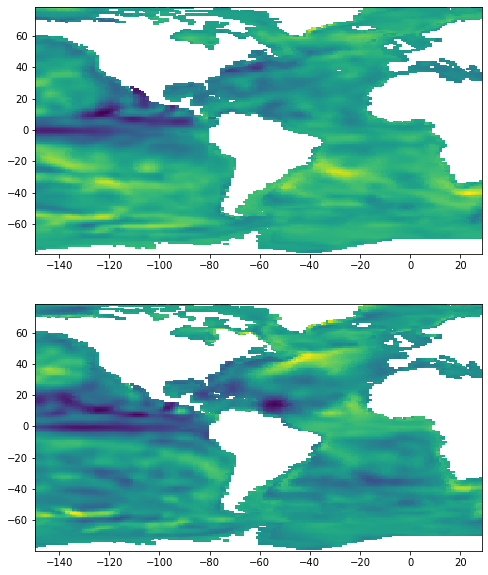

In [71]:
f, (ax1,ax2) = plt.subplots(2,1,figsize=(8,10))
ax1.pcolor(new_grid_lon,new_grid_lat,ecco_zeta_rho_month[0,:,:])
ax2.pcolor(new_grid_lon,new_grid_lat,ecco_zeta_rho_month[11,:,:])

In [38]:
# collapse two horizontal dimensions to one 
ecco_zeta_rho_month_0 = ecco_zeta_rho_month.stack(k=("j", "i")) # .unstack("z")

In [57]:
# OLD 
# remove nan (land) timeseries 
ecco_zeta_rho_month_1 = ecco_zeta_rho_month_0[:,~np.isnan(ecco_zeta_rho_month_0[0,:].data)]
# interpolate remaining nans (some locations have nans at times)
# for i in range(np.shape(ecco_zeta_rho_month_w)[1]):
ecco_zeta_rho_month_w = ecco_zeta_rho_month_1.interpolate_na(dim='time')

In [58]:
np.where(np.isnan(ecco_zeta_rho_month_w))

(array([119, 119]), array([667, 668]))

In [59]:
# fudge this for now 
# ecco_zeta_rho_month_w[239,26664] = ecco_zeta_rho_month_w[238,26664] - 0.001
ecco_zeta_rho_month_w[119,667] = ecco_zeta_rho_month_w[119,666] - 0.001
ecco_zeta_rho_month_w[119,668] = ecco_zeta_rho_month_w[119,669] - 0.001

In [60]:
np.where(np.isnan(ecco_zeta_rho_month_w))

(array([], dtype=int64), array([], dtype=int64))

In [61]:
# Tide Gauge: interpolate nans and remove bad timeseries 
tg_g = []
for i in range(np.shape(tide_gauge_anom_month)[1]):
    tide_gauge_anom_month[:,i] = tide_gauge_anom_month[:,i].interpolate_na(dim='time')
    if np.sum(np.isnan(tide_gauge_anom_month[:,i].data)) < 1:
        tg_g.append(i)
    # print(np.sum(np.isnan(tide_gauge_anom_month[:,i].data)))
tide_gauge_anom_month_w = tide_gauge_anom_month[:,tg_g]

In [64]:
print(np.shape(tide_gauge_anom_month_w))
print(np.shape(ecco_zeta_rho_month_w))

(120, 32)
(120, 19587)


In [65]:
covm = np.matrix(ecco_zeta_rho_month_w).transpose()*np.matrix(tide_gauge_anom_month_w)

In [66]:
U,S,V = np.linalg.svd(covm)

In [67]:
print(S[0]**2/np.sum(S**2))
print(S[1]**2/np.sum(S**2))

0.9589002549269405
0.019172327482961656


In [105]:
steric_ec = np.matrix(ecco_zeta_rho_month_w)*np.matrix(U)
tg_ec = np.matrix(tide_gauge_anom_month_w)*np.matrix(V)

In [107]:
np.shape(V)

(32, 32)

In [88]:
np.shape(ecco_zeta_rho_month_w[:,i])

(120,)

In [109]:
re_map1 = np.nan*np.ones(np.shape(ecco_zeta_rho_month[0,:,:]))
re_corr1 = np.nan*np.ones(np.shape(ecco_zeta_rho_month[0,:,:]))
re_map2 = np.nan*np.ones(np.shape(ecco_zeta_rho_month[0,:,:]))
for i in range(len(U[:,0])):
    kij = ecco_zeta_rho_month_w.k.data[i]
    loni = np.where(new_grid_lon == kij[1])[0]
    lati = np.where(new_grid_lat == kij[0])[0]
    cor1 = np.corrcoef(np.squeeze(steric_ec[:,0]),ecco_zeta_rho_month_w[:,i])
    re_map1[lati,loni] = U[i,0]
    re_corr1[lati,loni] = cor1[0,1]
    re_map2[lati,loni] = U[i,1]

re_corr2 = np.nan*np.ones(np.shape(tide_gauge_anom_month_w[0]))
for i in range(len(V[:,0])):
    cor2 = np.corrcoef(np.squeeze(tg_ec[:,0]),tide_gauge_anom_month_w[:,i])
    re_corr2[i] = cor2[0,1]

In [115]:
re_corr2

array([0.31223073, 0.47214313, 0.62819283, 0.62821106, 0.66971348,
       0.67805007, 0.74206034, 0.7037413 , 0.74555267, 0.82455762,
       0.75881963, 0.84072645, 0.83109178, 0.79121522, 0.81978848,
       0.91521094, 0.90961668, 0.91379096, 0.91526648, 0.88663048,
       0.8692679 , 0.90725945, 0.91818023, 0.90845732, 0.79237125,
       0.86842094, 0.89021269, 0.90346804, 0.91327702, 0.88195338,
       0.85594271, 0.79846753])

In [113]:
tgcmp = plt.get_cmap('RdBu_r')

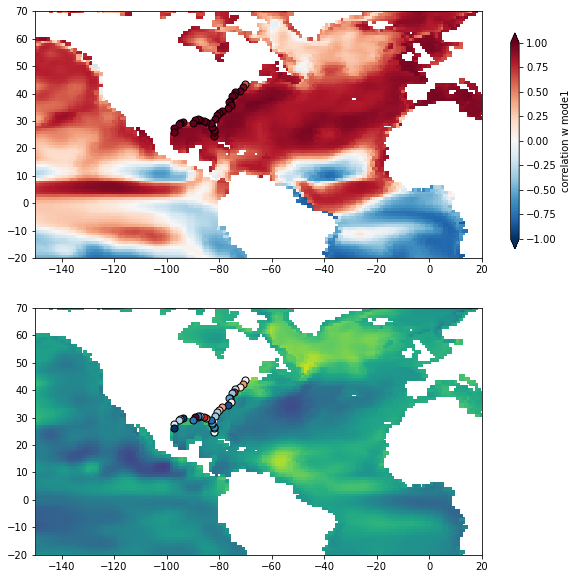

In [116]:
xbs = [-150,20]; ybs = [-20,70]
f, (ax1,ax2) = plt.subplots(2,1,figsize=(8,10))
# -- mode1 pattern -- 
# ax1.pcolor(new_grid_lon,new_grid_lat,re_map1)
# for i in range(len(V[:,0])):
#     ax1.scatter(tide_gauge_anom_month_w.lon[i],tide_gauge_anom_month_w.lat[i],\
#                 s=50,color=tgcmp((V[i,0]-np.nanmin(V[:,0]))/(np.nanmax(V[:,0])-np.nanmin(V[:,0]))),edgecolor='k')

# -- correlation map -- 
cc = ax1.pcolor(new_grid_lon,new_grid_lat,re_corr1,vmin=-1,vmax=1,cmap='RdBu_r')
for i in range(len(V[:,0])):
    ax1.scatter(tide_gauge_anom_month_w.lon[i],tide_gauge_anom_month_w.lat[i],\
                s=50,color=tgcmp(re_corr2[i]+1/2),edgecolor='k')
    
ax1.set_xlim(xbs); ax1.set_ylim(ybs);
cbpos = [0.95, 0.55, 0.015, 0.3]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='both', label='correlation w mode1');
#################################
ax2.pcolor(new_grid_lon,new_grid_lat,re_map2)
for i in range(len(V[:,0])):
    ax2.scatter(tide_gauge_anom_month_w.lon[i],tide_gauge_anom_month_w.lat[i],\
                s=50,color=tgcmp((V[i,1]-np.nanmin(V[:,1]))/(np.nanmax(V[:,1])-np.nanmin(V[:,1]))),edgecolor='k')
ax2.set_xlim(xbs); ax2.set_ylim(ybs);